In [44]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import torch
import torch.nn.functional as F

from torchvision import models
from torchvision import transforms


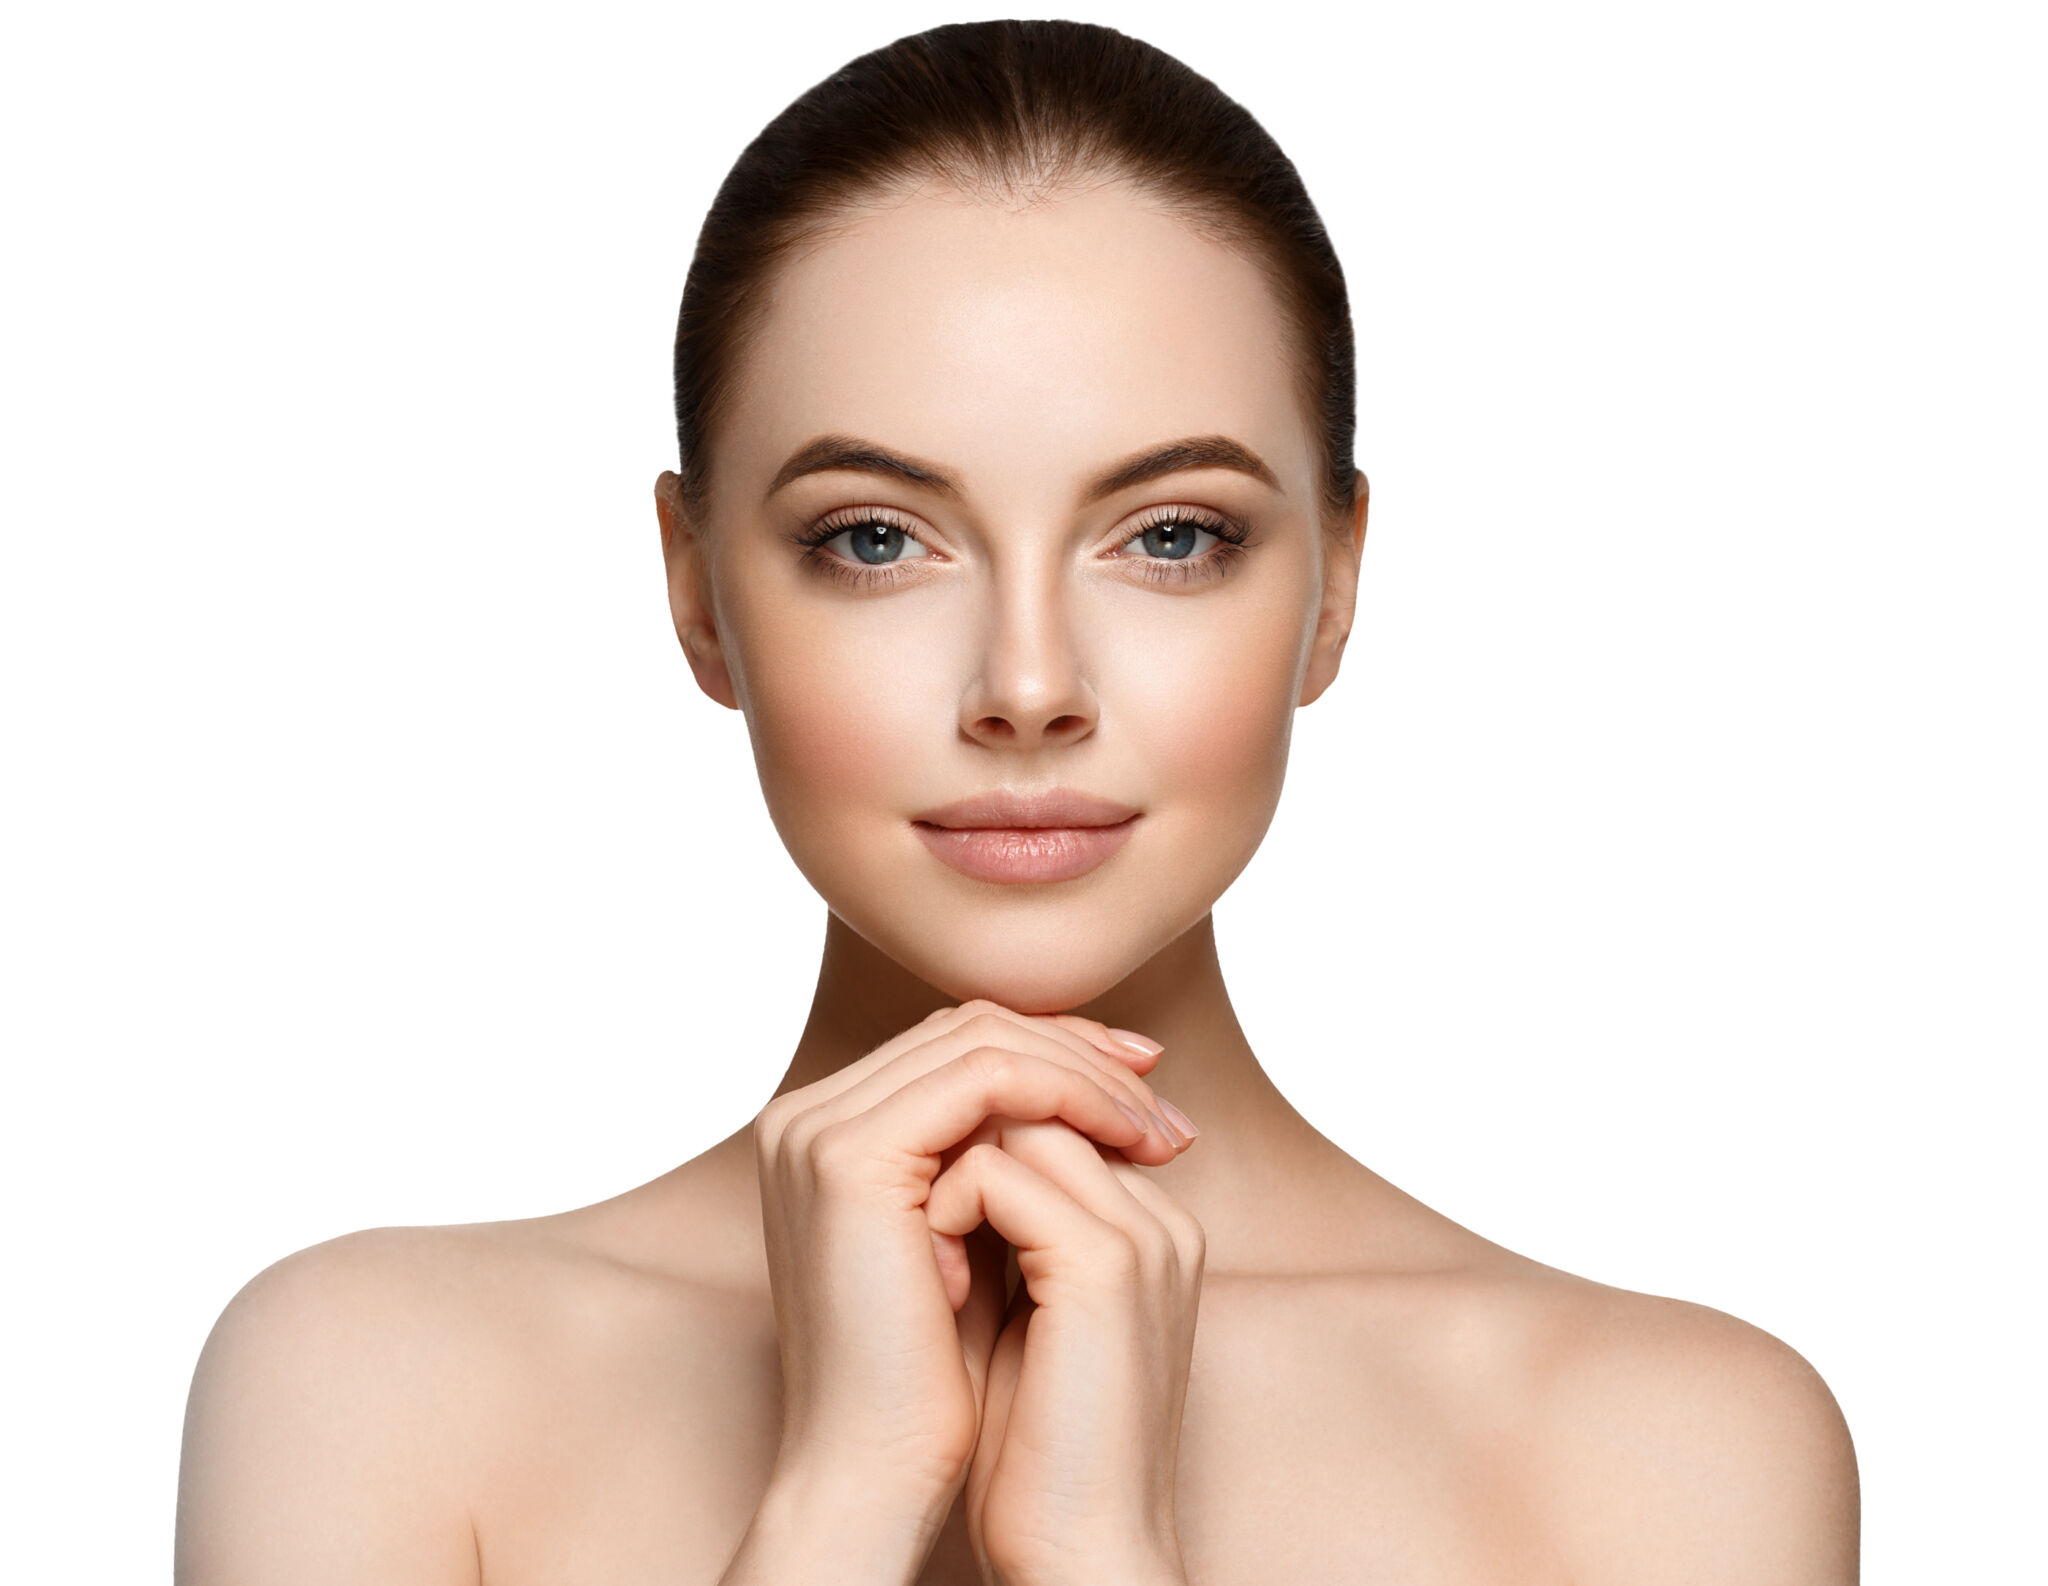

In [45]:
img = Image.open('D:\\online class\\DeepLearning\\gradCAM\\face.jpg')
img

In [46]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_tensor = preprocess(img).unsqueeze(0)
input_tensor.shape


torch.Size([1, 3, 224, 224])

### Loading model

In [47]:
resnet_model = models.resnet18(pretrained=True)
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [48]:
class GradCAM:
    def __init__(self, model, target_layer) -> None:
        self.model = model
        self.target_layer = target_layer
        self.activation_maps = None
        self.gradient_maps = None
        self.hook()

    def hook(self):
        def forward_hook(module, in_activation_maps,out_activation_maps):
            self.activation_maps = out_activation_maps

        def backward_hook(module, grad_in, grad_out):
            self.gradient_maps = grad_out[0]

        target_layer_module = dict(self.model.named_modules())[self.target_layer]
        target_layer_module.register_forward_hook(forward_hook)
        target_layer_module.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor):
        output = self.model(input_tensor)
        class_idx = torch.argmax(output, dim=1)
    
        self.model.zero_grad()

        target_class = output[:, class_idx]
        target_class.backward()

        # Compute Global Average Pooling
        weights = torch.mean(self.gradient_maps, dim=(2, 3))

        cam = torch.zeros(self.activation_maps.shape[2:],dtype=torch.float32)

        for i, w in enumerate(weights[0]):
            cam += w * self.activation_maps[0, i, :, :]

        cam = F.relu(cam)
        return (cam - cam.min()) / (cam.max() - cam.min())

grad_cam = GradCAM(resnet_model, 'layer4')
cam = grad_cam.generate_cam(input_tensor)


In [49]:
orginal_img = np.array(img)
if orginal_img.ndim == 2:
    orginal_img = cv2.cvtColor(orginal_img, cv2.COLOR_GRAY2BGR)
else:
    orginal_img = cv2.cvtColor(orginal_img, cv2.COLOR_RGB2BGR)
orginal_img = np.float32(orginal_img) / 255

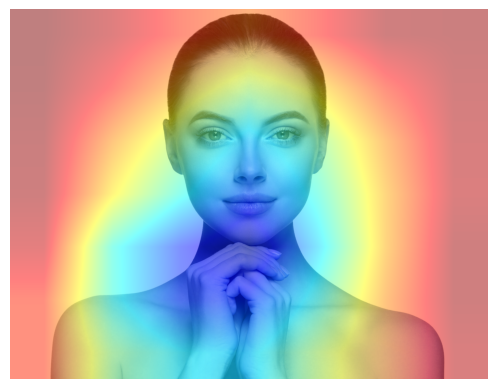

In [50]:
cam = cam.detach().numpy()
cam = cv2.resize(cam, (orginal_img.shape[1], orginal_img.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(cam * 255), cv2.COLORMAP_JET)
overlay = heatmap / 255 + orginal_img
overlay = overlay / np.max(overlay)
plt.imshow(overlay)
plt.axis('off')
plt.show()